In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


MNIST 손글씨 데이터를 오토인코더를 사용해서 차원축소 후 시각화한다.

MNIST 데이터를 획득한다.

In [3]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

In [4]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)


MNIST 데이터 전처리  
획득된 학습 데이터는 오토인코더 학습에 사용하고 테스트 데이터 중 300개의 데이터만 선택해서 시각화에 사용한다.

In [5]:
x_train = x_train.reshape(60000, 784) # 학습 데이터

# 테스트 데이터 중 300개만 선택해서 테스트 데이터로 사용한다. => 데이터 시각화에 사용한다.
x_test = x_test[:300]
y_test = y_test[:300]
x_test = x_test.reshape(300, 784)

# 데이터 정규화
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
gray_scale = 255
x_train /= gray_scale
x_test /= gray_scale

오토인코더 구조  
텐서플로우로 구현할 오토인코더는 아래 그림과 같은 구조를 가진다.

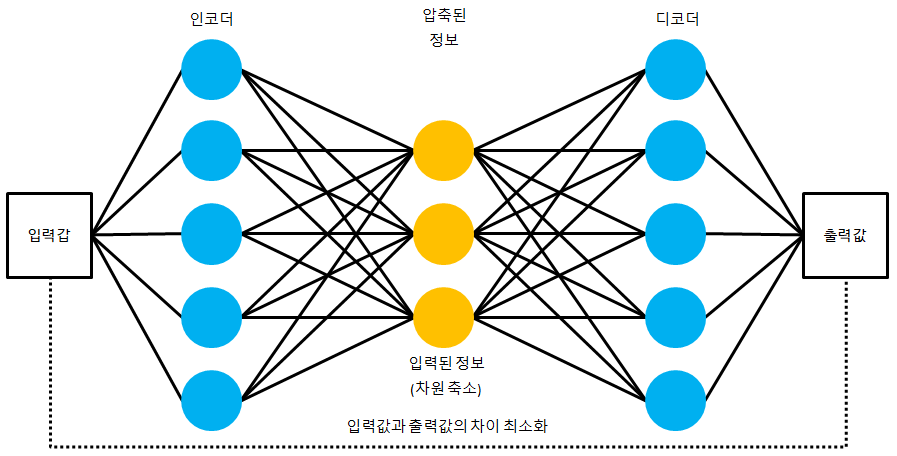

In [6]:
from IPython.display import Image
Image('./autoEncoder.png', width='900')

텐서플로우 모델을 만든다.

In [7]:
# 텐서플로우 모델을 구현한다. 손실 함수는 입력값과 출력값의 차이를 최소화하는 것으로 설정한다.
_input = tf.placeholder(tf.float32, [None, 28 * 28])       # 입력
encoder = tf.layers.dense(_input, 128, tf.nn.tanh)         # 인코더
bottleneck = tf.layers.dense(encoder, 3)                   # 차원축소
decoder = tf.layers.dense(bottleneck, 128, tf.nn.tanh)     # 디코더
_output = tf.layers.dense(decoder, 28 * 28, tf.nn.sigmoid) # 출력
loss = tf.losses.mean_squared_error(labels=_input, predictions=_output) # 손실함수
train = tf.train.AdamOptimizer(0.002).minimize(loss)       # 최적화

학습 데이터를 batch_size개씩 나눠서 데이터 학습을 진행한다.

In [8]:
# tf.reset_default_graph()
tf.set_random_seed(35)
epoch_cnt = 50
batch_size = 5000
iteration = len(x_train) // batch_size

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    print('학습 시작...')
    for epoch in range(epoch_cnt):
        avg_loss = 0.0
        start = 0
        end = batch_size
        for i in range(iteration):
            _, loss_ = sess.run([train, loss], feed_dict={_input: x_train[start:end]})
            start += batch_size
            end += batch_size
            # 손실 계산
            avg_loss += loss_ / iteration
        print('epoch: {0:2d}, train loss: {1:5.3f}'.format(epoch, avg_loss))
    # 학습을 완료한 후 오토인코더의 가운데 부분에 3차원으로 압축된 벡터를 별도로 저장한다.
    _bottleneck = sess.run(bottleneck, {_input: x_test})

학습 시작...
epoch:  0, train loss: 0.150
epoch:  1, train loss: 0.070
epoch:  2, train loss: 0.068
epoch:  3, train loss: 0.068
epoch:  4, train loss: 0.067
epoch:  5, train loss: 0.067
epoch:  6, train loss: 0.065
epoch:  7, train loss: 0.063
epoch:  8, train loss: 0.061
epoch:  9, train loss: 0.060
epoch: 10, train loss: 0.059
epoch: 11, train loss: 0.058
epoch: 12, train loss: 0.058
epoch: 13, train loss: 0.057
epoch: 14, train loss: 0.056
epoch: 15, train loss: 0.056
epoch: 16, train loss: 0.055
epoch: 17, train loss: 0.054
epoch: 18, train loss: 0.053
epoch: 19, train loss: 0.053
epoch: 20, train loss: 0.052
epoch: 21, train loss: 0.052
epoch: 22, train loss: 0.052
epoch: 23, train loss: 0.051
epoch: 24, train loss: 0.051
epoch: 25, train loss: 0.050
epoch: 26, train loss: 0.050
epoch: 27, train loss: 0.050
epoch: 28, train loss: 0.049
epoch: 29, train loss: 0.049
epoch: 30, train loss: 0.049
epoch: 31, train loss: 0.048
epoch: 32, train loss: 0.048
epoch: 33, train loss: 0.048
epoch

압축된 데이터를 시각화 한다.

In [9]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

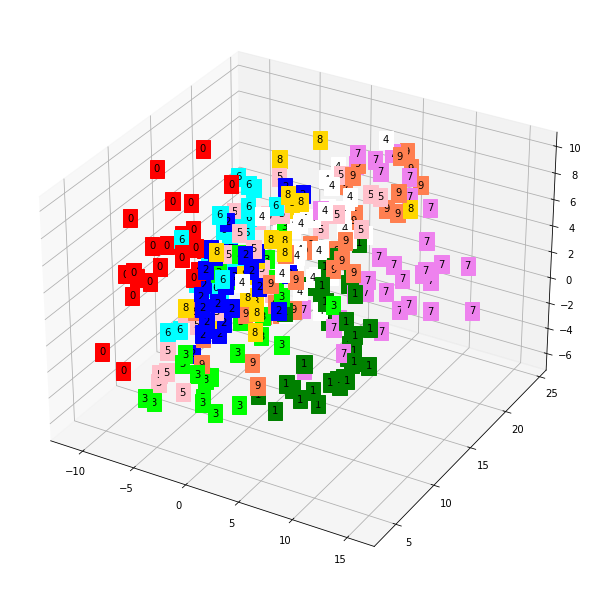

In [14]:
from pylab import rcParams
rcParams['figure.figsize'] = [10, 8]

fig = plt.figure(1)
ax = Axes3D(fig)

xs = _bottleneck[:, 0]
ys = _bottleneck[:, 1]
zs = _bottleneck[:, 2]

color = ['red', 'green', 'blue', 'lime', 'white', 'pink', 'aqua', 'violet', 'gold', 'coral']
for x, y, z, label in zip(xs, ys, zs, y_test):
    c = color[int(label)]
    ax.text(x, y, z, label, backgroundcolor=c)

ax.set_xlim(xs.min(), xs.max())
ax.set_ylim(ys.min(), ys.max())
ax.set_zlim(zs.min(), zs.max())
plt.show()